In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
from scipy import stats
from sklearn.neighbors import LocalOutlierFactor
import scipy.spatial.distance
from scipy.special import erf
import math


In [10]:
# Define the sensor files and columns
sensor_files = {
    'accelerometer': 'Combined_Accelerometer_1s.csv',
    'gyroscope': 'Combined_Gyroscope_1s.csv',
    'linear_accelerometer': 'Combined_Linear Accelerometer_1s.csv',
    'magnetometer': 'Combined_Magnetometer_1s.csv'
}

sensor_columns = {
    'accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'gyroscope': ['X (rad/s)', 'Y (rad/s)', 'Z (rad/s)'],
    'linear_accelerometer': ['X (m/s^2)', 'Y (m/s^2)', 'Z (m/s^2)'],
    'magnetometer': ['X (µT)', 'Y (µT)', 'Z (µT)']
}

# Define the base path
base_path = '/Users/priyank/Desktop/ML4QS-project/Wave_right_5mins/Combined Data 1s'


In [11]:
# Implements the Kalman filter for single columns.
class KalmanFilters:
    def apply_kalman_filter(self, data_table, col):
        kf = KalmanFilter(transition_matrices=[[1]], observation_matrices=[[1]])
        numpy_array_state = data_table[col].values
        numpy_array_state = numpy_array_state.astype(np.float32)
        numpy_matrix_state_with_mask = np.ma.masked_invalid(numpy_array_state)
        kf = kf.em(numpy_matrix_state_with_mask, n_iter=10)
        (new_data, filtered_state_covariances) = kf.filter(numpy_matrix_state_with_mask)
        data_table[col + '_kalman'] = new_data
        return data_table


In [12]:
# Utility function to normalize dataset
def normalize_dataset(data, cols):
    for col in cols:
        data[col] = (data[col] - data[col].mean()) / data[col].std()
    return data

# Function to detect outliers using Local Outlier Factor (LOF)
def detect_outliers_lof(data_table, cols, d_function='euclidean', k=5):
    new_data_table = normalize_dataset(data_table.dropna(axis=0, subset=cols), cols)
    lof = LocalOutlierFactor(n_neighbors=k, metric=d_function)
    for col in cols:
        df_col = new_data_table[col].values.reshape(-1, 1)
        outlier_flags = lof.fit_predict(df_col)
        print(f"LOF outlier flags for {col}: {np.unique(outlier_flags, return_counts=True)}")  # Debugging output
        data_table[col + '_lof'] = np.where(outlier_flags == -1, np.nan, data_table[col])
    return data_table


In [13]:
# Load the dataset
def load_data(filename):
    file_path = os.path.join(base_path, filename)
    return pd.read_csv(file_path)

def calculate_changes(data, original_col, filtered_col):
    diff = data[filtered_col].isna() | (np.abs(data[original_col] - data[filtered_col]) > 0)
    num_changes = diff.sum()
    perc_changes = (num_changes / len(data) * 100).round(2)
    return num_changes, perc_changes


In [14]:
def apply_kalman_and_compare(data, cols):
    kf_instance = KalmanFilters()
    summary_results = []

    for col in cols:
        # Apply Kalman filter
        data = kf_instance.apply_kalman_filter(data, col)
        num_changes_kalman, perc_changes_kalman = calculate_changes(data, col, col + '_kalman')

        summary_results.append({
            'Sensor Type': col,
            'Kalman_Num_Changes': num_changes_kalman,
            'Kalman_Perc_Changes': perc_changes_kalman,
        })

        # Plot original vs Kalman filtered data
        plt.figure(figsize=(10, 6))
        plt.plot(data['time'], data[col], label='Original')
        plt.plot(data['time'], data[col + '_kalman'], label='Kalman Filtered')
        plt.title(f'{col} - Original vs Kalman Filtered')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

    return pd.DataFrame(summary_results)


In [15]:
def apply_lof_and_compare(data, cols):
    summary_results = []

    # Apply LOF
    data = detect_outliers_lof(data, cols)
    for col in cols:
        num_changes_lof, perc_changes_lof = calculate_changes(data, col, col + '_lof')

        summary_results.append({
            'Sensor Type': col,
            'LOF_Num_Changes': num_changes_lof,
            'LOF_Perc_Changes': perc_changes_lof,
        })

        # Plot original vs LOF data
        plt.figure(figsize=(10, 6))
        plt.plot(data['time'], data[col], label='Original')
        plt.plot(data['time'], data[col + '_lof'], label='LOF Filtered', linestyle='None', marker='o')
        plt.title(f'{col} - Original vs LOF Filtered')
        plt.xlabel('Time (s)')
        plt.legend()
        plt.show()

    return pd.DataFrame(summary_results)


Initial statistics for accelerometer from Combined_Accelerometer_1s.csv:
        X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  303.000000  303.000000  303.000000
mean    -1.371713   -0.540689    2.288597
std      3.769411    4.762069    2.782546
min    -19.577039  -17.323696   -4.879653
25%     -3.446558   -3.172486    0.366861
50%     -1.440733    0.355470    2.566180
75%      0.636301    2.406490    4.059738
max     30.706994    9.893447   13.162728


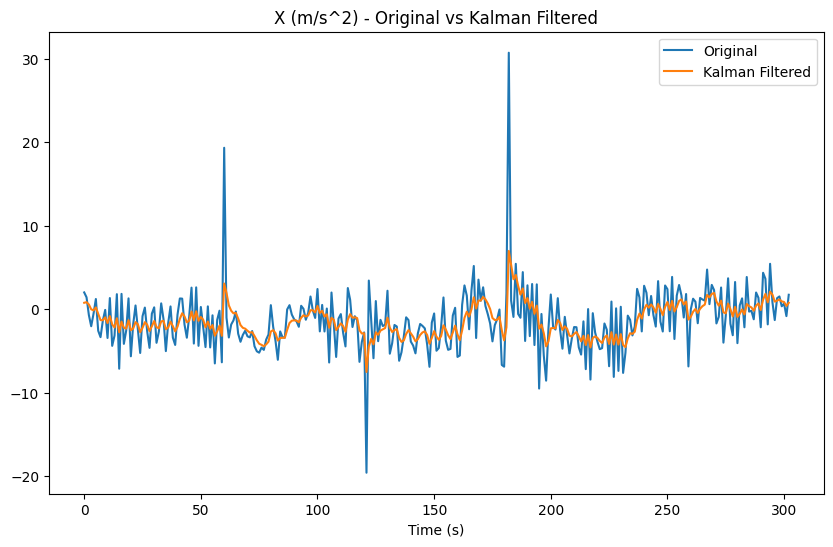

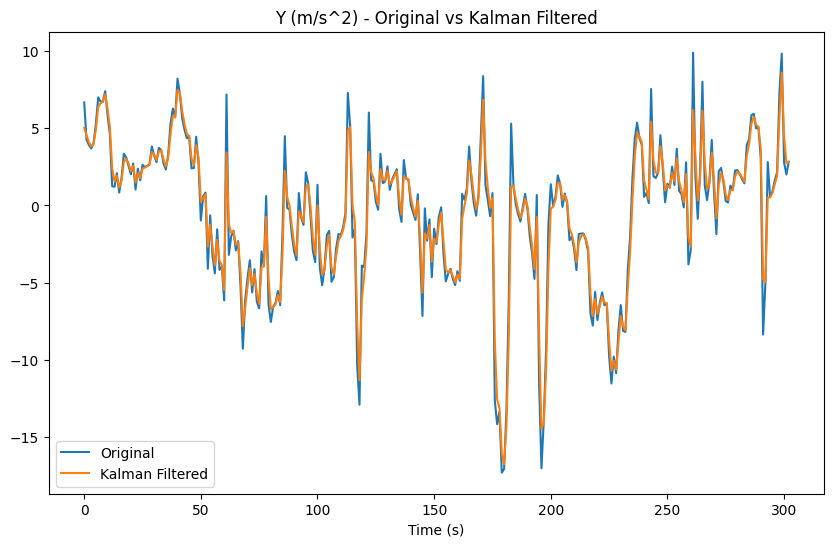

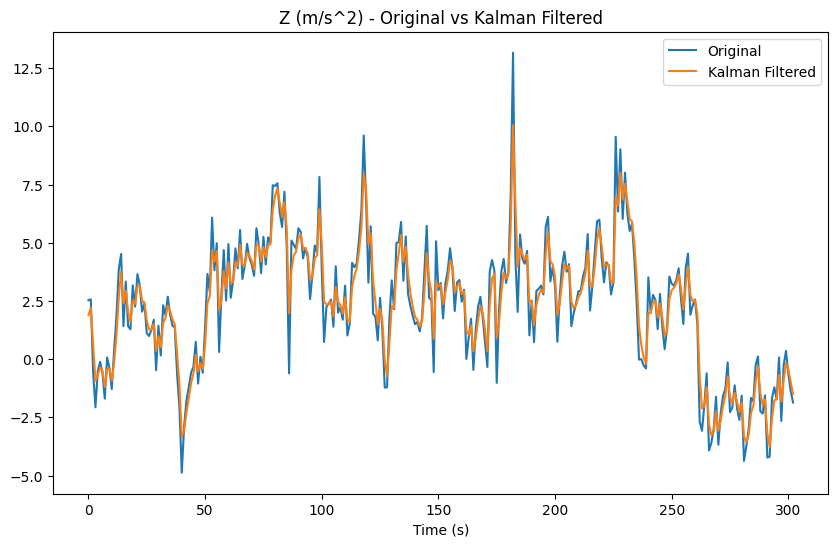

LOF outlier flags for X (m/s^2): (array([-1,  1]), array([ 34, 269]))
LOF outlier flags for Y (m/s^2): (array([-1,  1]), array([ 23, 280]))
LOF outlier flags for Z (m/s^2): (array([-1,  1]), array([ 15, 288]))


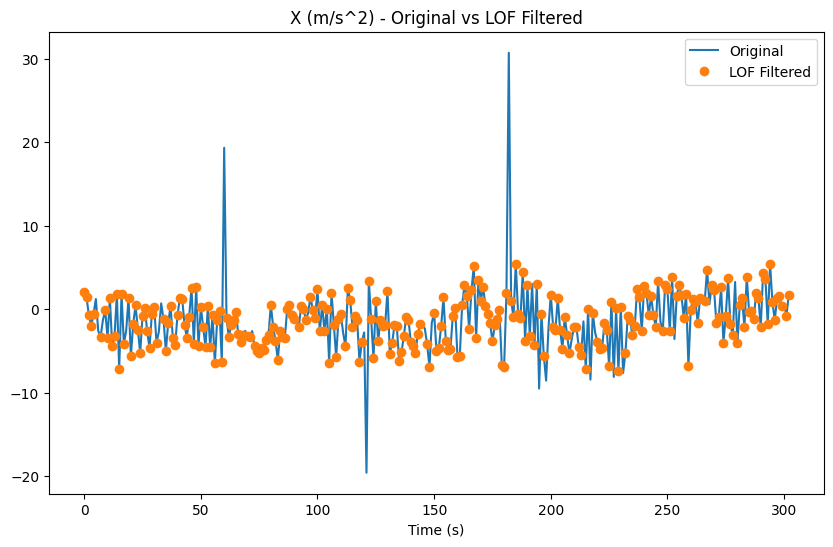

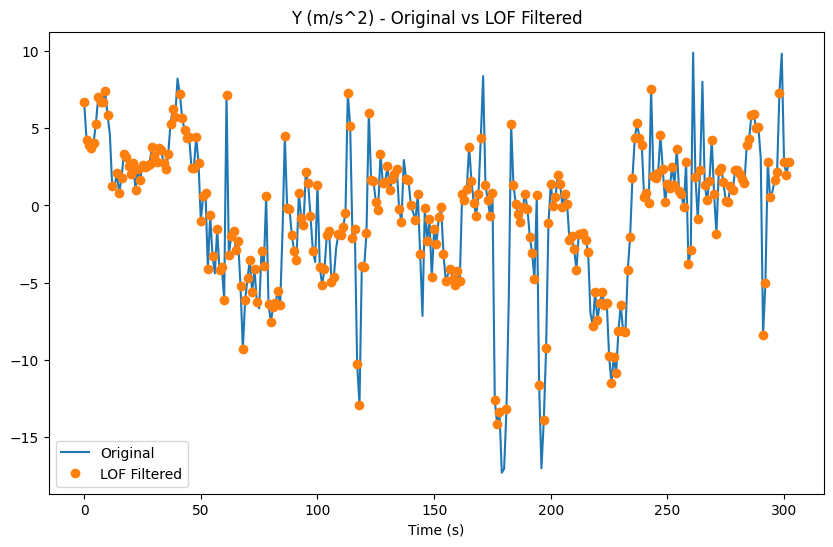

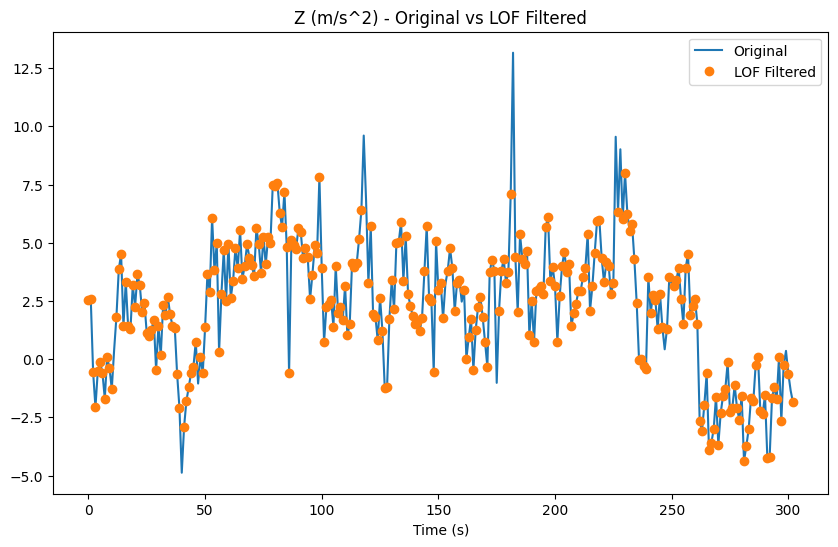

Initial statistics for gyroscope from Combined_Gyroscope_1s.csv:
        X (rad/s)   Y (rad/s)   Z (rad/s)
count  301.000000  301.000000  301.000000
mean     0.272311   -0.029773    0.086288
std      0.425200    0.434390    0.936884
min     -2.813387   -1.452371   -1.896337
25%      0.020487   -0.254154   -0.473007
50%      0.302468   -0.031823    0.061694
75%      0.519161    0.185358    0.609541
max      1.628700    2.410328    8.012442


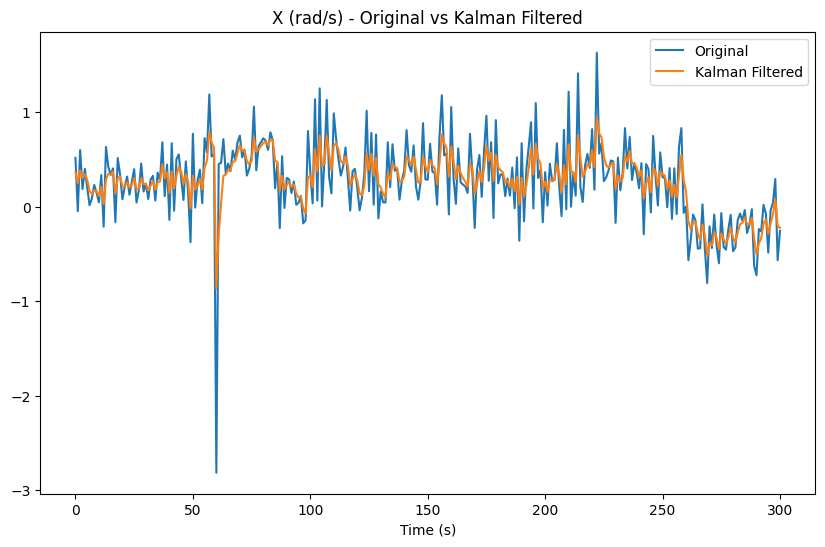

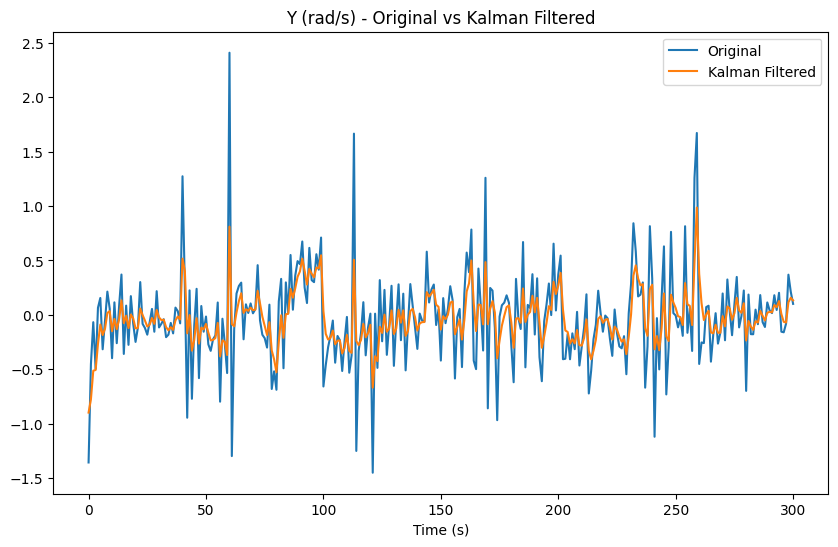

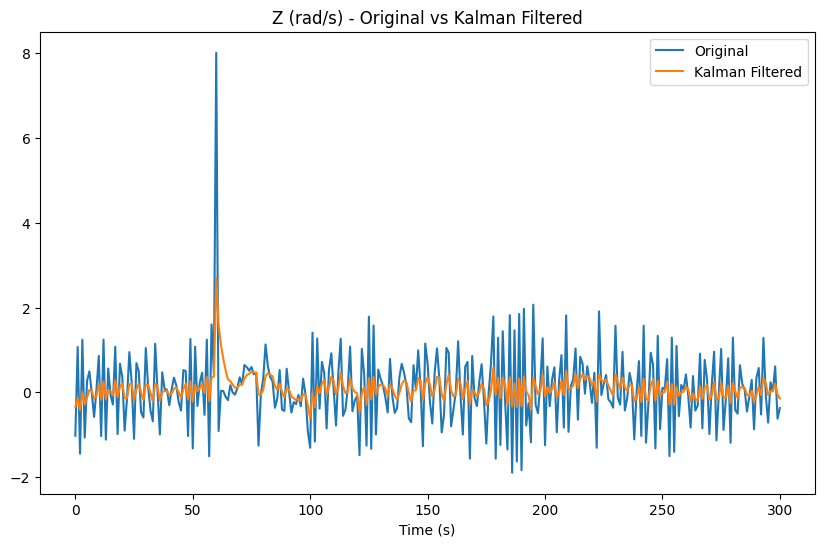

LOF outlier flags for X (rad/s): (array([-1,  1]), array([ 22, 279]))
LOF outlier flags for Y (rad/s): (array([-1,  1]), array([ 29, 272]))
LOF outlier flags for Z (rad/s): (array([-1,  1]), array([ 18, 283]))


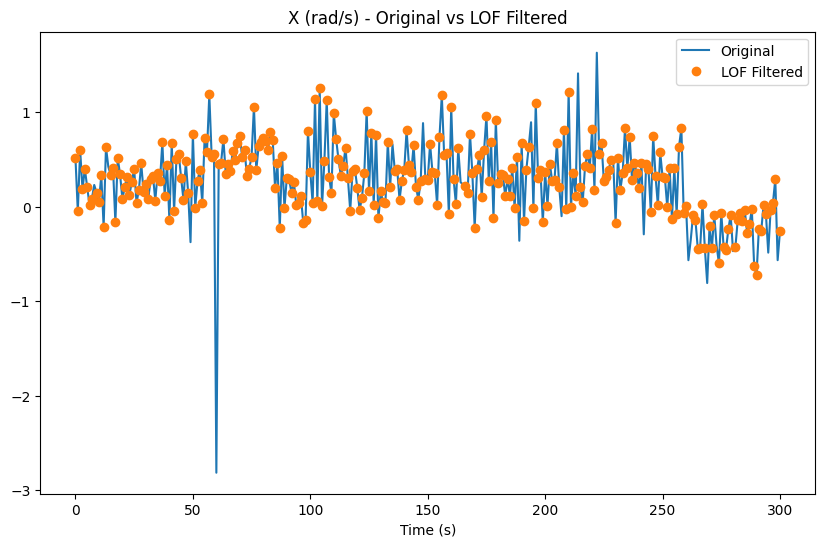

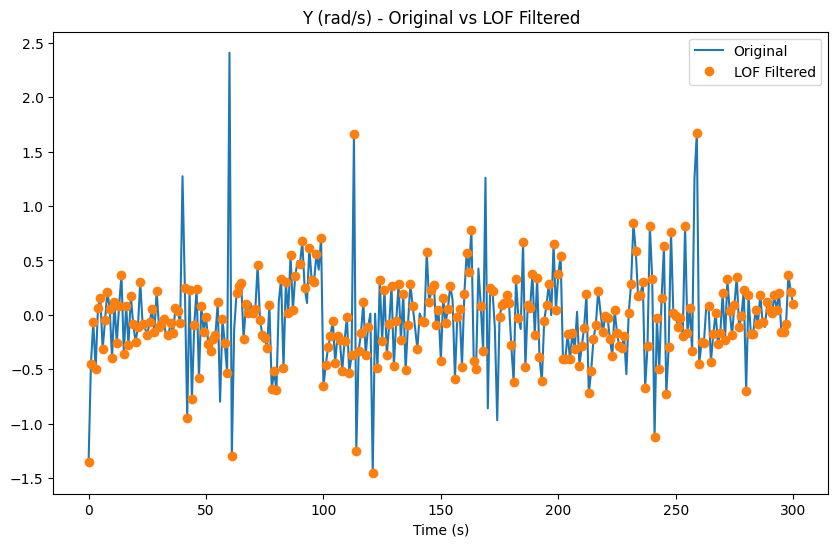

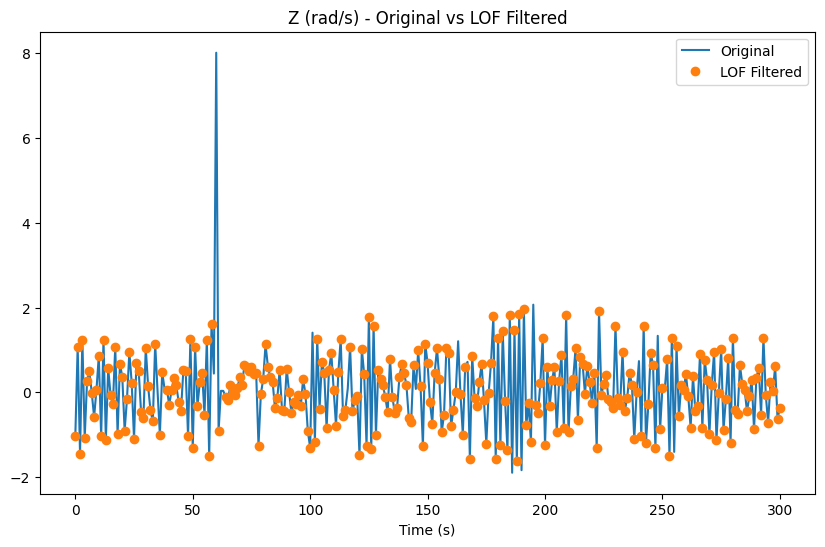

Initial statistics for linear_accelerometer from Combined_Linear Accelerometer_1s.csv:
        X (m/s^2)   Y (m/s^2)   Z (m/s^2)
count  301.000000  301.000000  301.000000
mean     0.470541   -8.297380    0.744653
std      2.075899    3.915372    1.510528
min     -5.253738  -21.196157   -2.538403
25%     -0.855741  -10.552438   -0.332987
50%      0.472092   -7.564053    0.540562
75%      1.767322   -5.902804    1.761038
max     17.883820    0.533413    5.876429


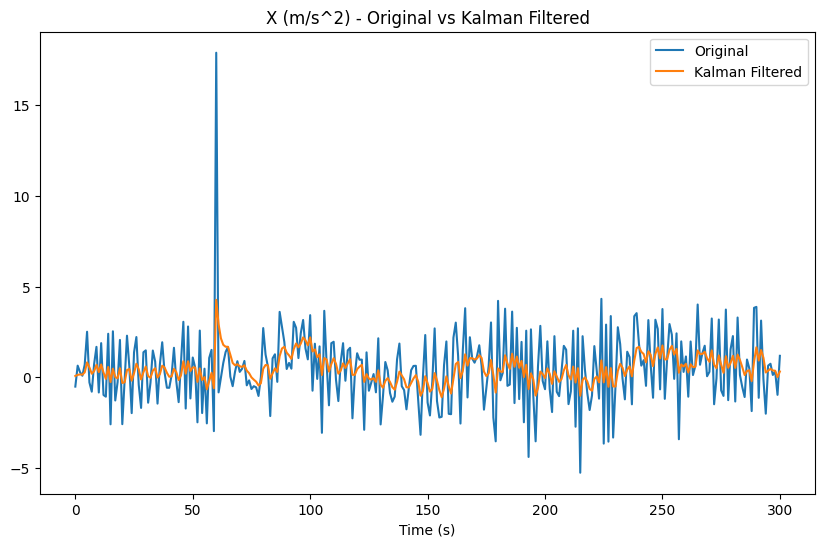

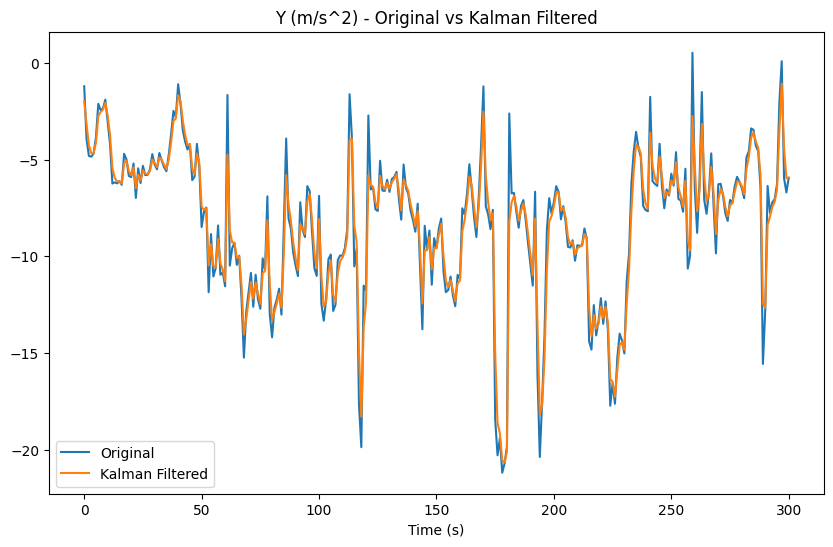

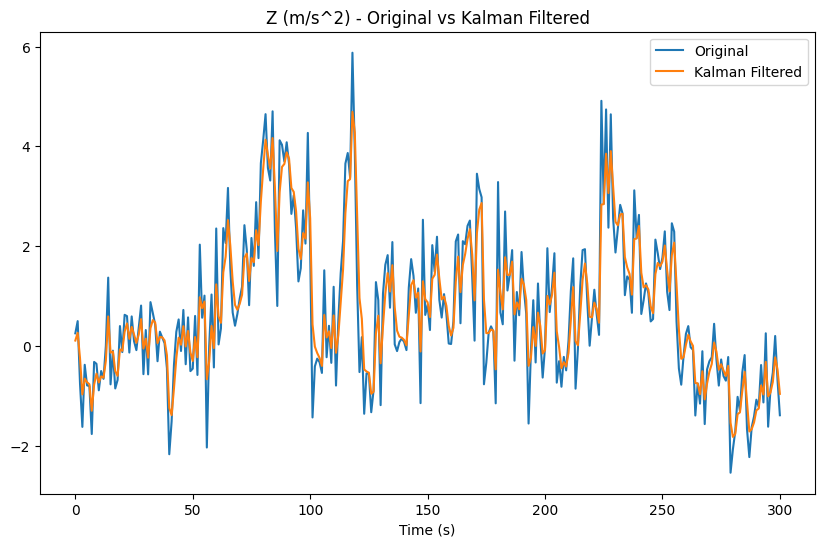

LOF outlier flags for X (m/s^2): (array([-1,  1]), array([ 18, 283]))
LOF outlier flags for Y (m/s^2): (array([-1,  1]), array([  8, 293]))
LOF outlier flags for Z (m/s^2): (array([-1,  1]), array([ 11, 290]))


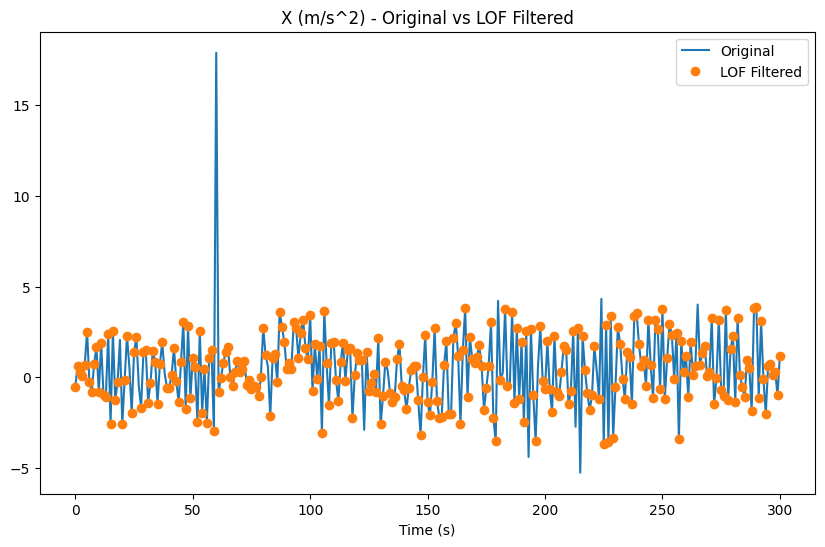

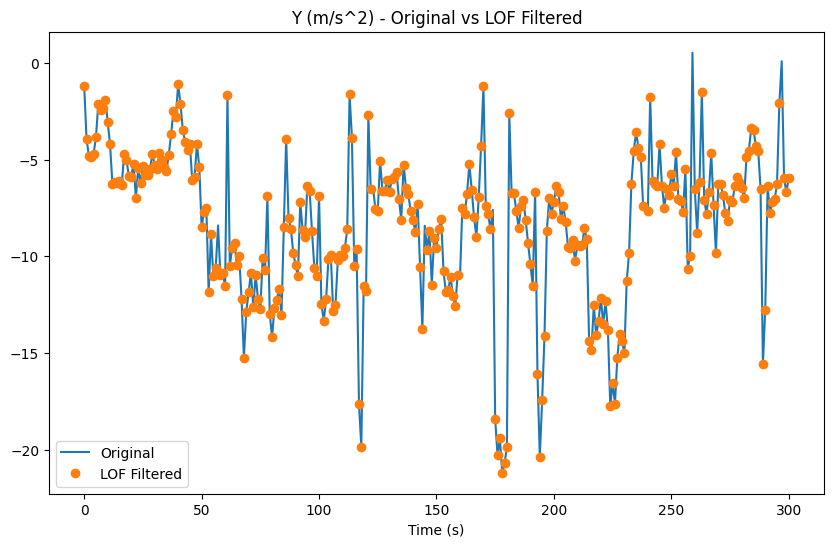

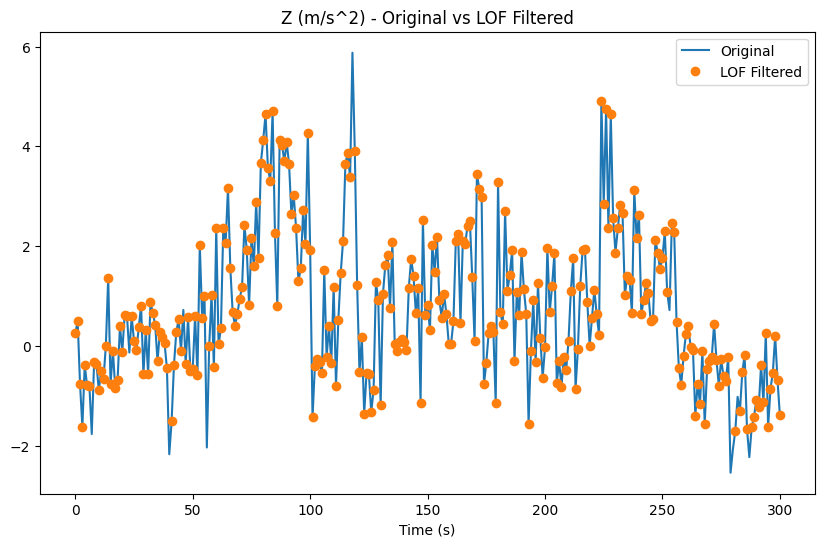

Initial statistics for magnetometer from Combined_Magnetometer_1s.csv:
           X (µT)      Y (µT)      Z (µT)
count  301.000000  301.000000  301.000000
mean    61.070166 -175.813454   94.110720
std    102.206093  334.031438  227.881584
min    -22.005771 -926.624417  -28.551880
25%     17.278889  -31.867043  -19.976398
50%     21.536179  -26.973798   -8.841839
75%     25.911619  -23.078317   19.538075
max    294.243498   -5.558359  628.666940


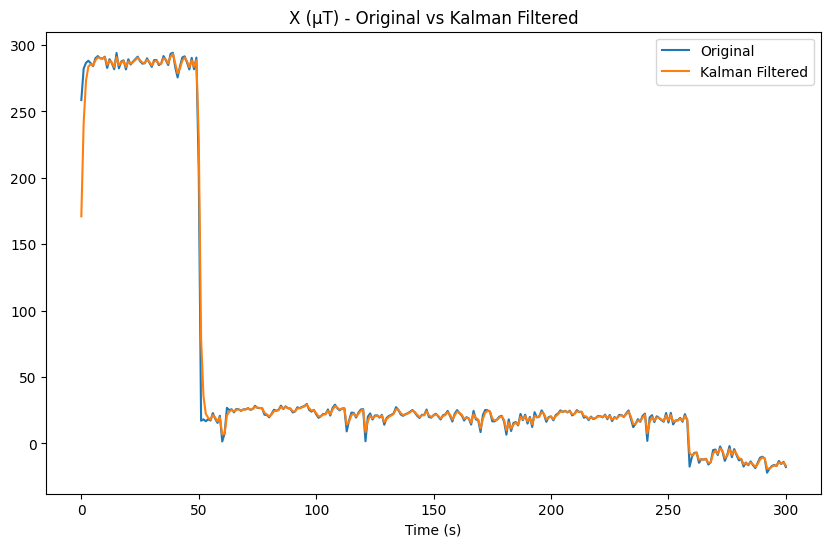

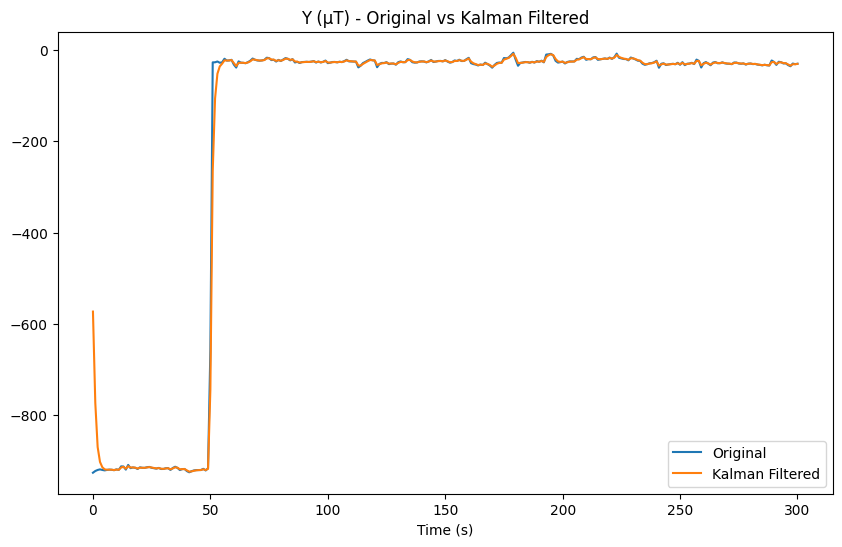

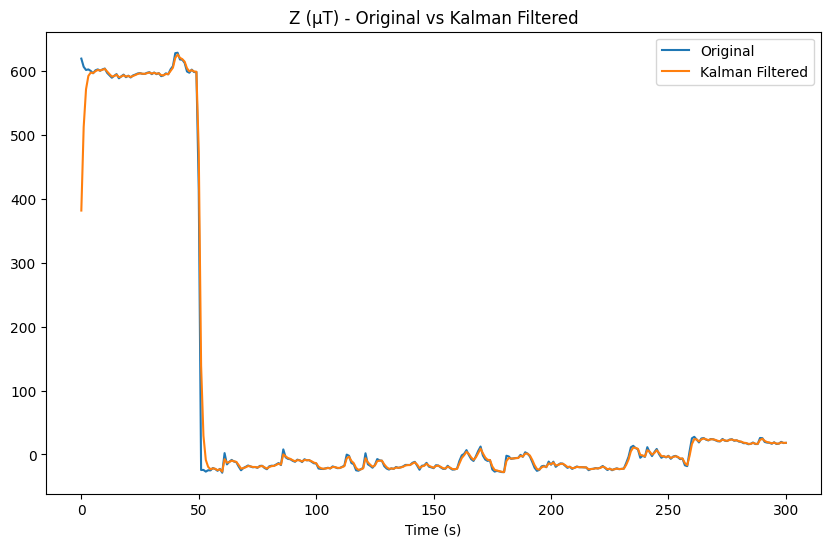

LOF outlier flags for X (µT): (array([-1,  1]), array([ 19, 282]))
LOF outlier flags for Y (µT): (array([-1,  1]), array([ 38, 263]))
LOF outlier flags for Z (µT): (array([-1,  1]), array([ 23, 278]))


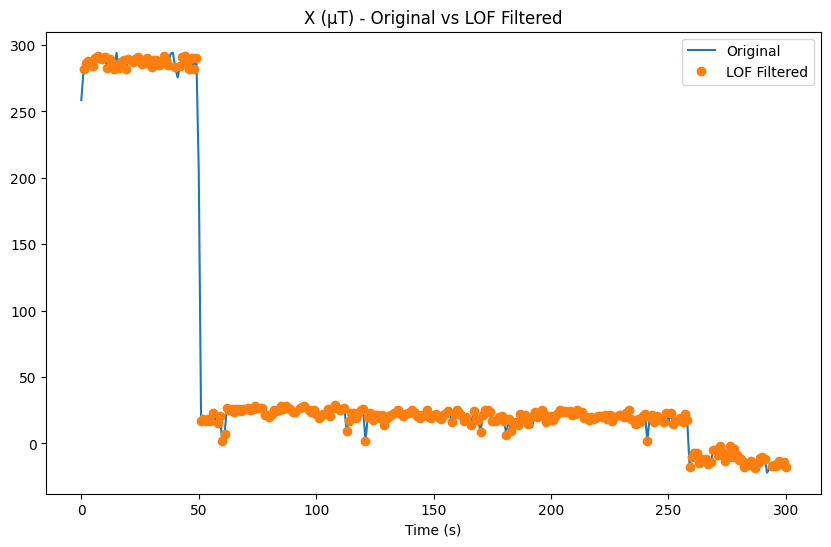

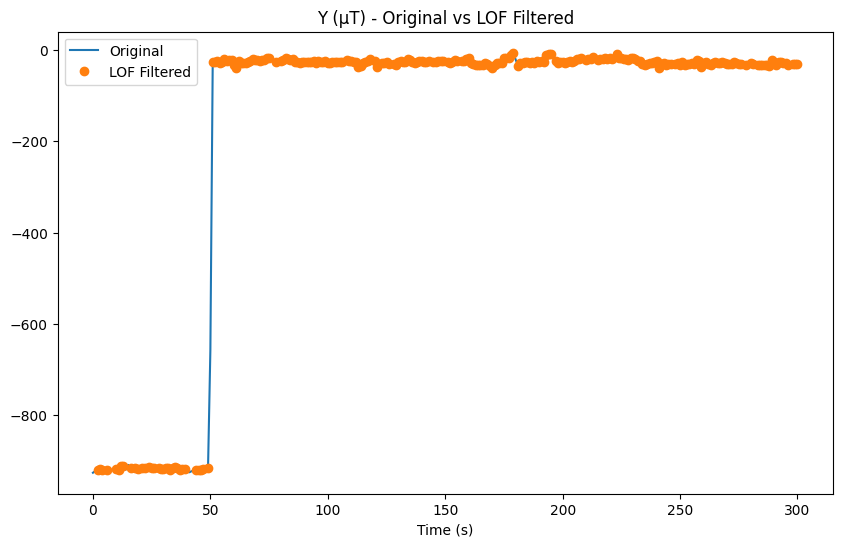

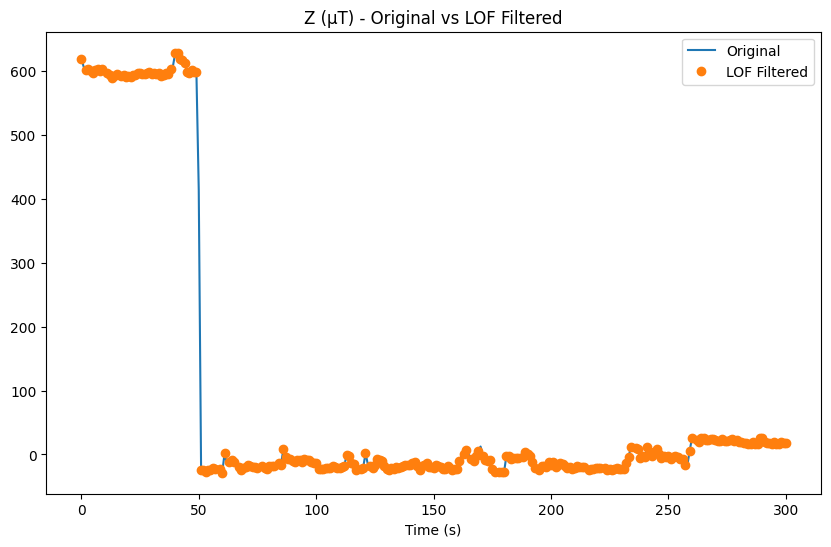

In [16]:
# Perform comparison on each combined file
kalman_summary_all = []
lof_summary_all = []

for sensor_type, filename in sensor_files.items():
    cols = sensor_columns[sensor_type]
    data = load_data(filename)
    
    # Initial data statistics
    print(f"Initial statistics for {sensor_type} from {filename}:")
    print(data[cols].describe())
    
    # Apply Kalman filter and compare
    kalman_summary = apply_kalman_and_compare(data.copy(), cols)
    kalman_summary['File'] = filename
    kalman_summary_all.append(kalman_summary)
    
    # Apply LOF and compare
    lof_summary = apply_lof_and_compare(data.copy(), cols)
    lof_summary['File'] = filename
    lof_summary_all.append(lof_summary)

# Concatenate all summaries
final_kalman_summary = pd.concat(kalman_summary_all, ignore_index=True)
final_lof_summary = pd.concat(lof_summary_all, ignore_index=True)

# Save the summaries to CSV files
final_kalman_summary.to_csv(os.path.join(base_path, 'kalman_filter_comparison_summary.csv'), index=False)
final_lof_summary.to_csv(os.path.join(base_path, 'lof_filter_comparison_summary.csv'), index=False)


In [17]:
# Display the final summaries
print("Kalman Filter Summary:")
print(final_kalman_summary)
print("\nLOF Summary:")
print(final_lof_summary)

Kalman Filter Summary:
   Sensor Type  Kalman_Num_Changes  Kalman_Perc_Changes  \
0    X (m/s^2)                 303                100.0   
1    Y (m/s^2)                 303                100.0   
2    Z (m/s^2)                 303                100.0   
3    X (rad/s)                 301                100.0   
4    Y (rad/s)                 301                100.0   
5    Z (rad/s)                 301                100.0   
6    X (m/s^2)                 301                100.0   
7    Y (m/s^2)                 301                100.0   
8    Z (m/s^2)                 301                100.0   
9       X (µT)                 301                100.0   
10      Y (µT)                 301                100.0   
11      Z (µT)                 301                100.0   

                                    File  
0          Combined_Accelerometer_1s.csv  
1          Combined_Accelerometer_1s.csv  
2          Combined_Accelerometer_1s.csv  
3              Combined_Gyroscope_1s.